In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

data_dir = "data/"
%pylab inline
pd.set_option('display.max_columns', 999)
import random
import time

Populating the interactive namespace from numpy and matplotlib


# Loading data

###  Independent variables

In [2]:
indep_df = pd.read_csv(data_dir + "independent_variables.csv")

In [3]:
indep_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
len(indep_df.id.drop_duplicates())/len(indep_df)

1

In [5]:
indep_df.set_index("id", inplace=True)

### Dependent variable

In [6]:
dep_df = pd.read_csv(data_dir + "dependent_variables.csv")

In [7]:
dep_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
dep_df.set_index("id", inplace=True)

In [9]:
len(indep_df)/float(len(dep_df))

1.0

# Preprocessing

###TODO

Missing values in construction year, populatoin

Clustering for latitude/longitude?

For categorical with many modes, add feature -> projection of mode in target space

In [10]:
indep_df.num_private.value_counts()

0       58643
6          81
1          73
5          46
8          46
32         40
45         36
15         35
39         30
93         28
3          27
7          26
2          23
65         22
47         21
102        20
4          20
17         17
80         15
20         14
25         12
11         11
41         10
34         10
16          8
120         7
150         6
22          6
12          5
24          5
        ...  
14          3
61          3
27          2
26          2
160         1
30          1
698         1
60          1
1402        1
450         1
668         1
131         1
35          1
672         1
42          1
136         1
87          1
300         1
280         1
141         1
62          1
111         1
240         1
1776        1
755         1
180         1
213         1
23          1
55          1
94          1
Name: num_private, dtype: int64

In [11]:
indep_df.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [12]:
indep_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [13]:
len(indep_df)

59400

In [14]:
indep_df.notnull().sum()/float(len(indep_df))

amount_tsh               1.000000
date_recorded            1.000000
funder                   0.938805
gps_height               1.000000
installer                0.938468
longitude                1.000000
latitude                 1.000000
wpt_name                 1.000000
num_private              1.000000
basin                    1.000000
subvillage               0.993754
region                   1.000000
region_code              1.000000
district_code            1.000000
lga                      1.000000
ward                     1.000000
population               1.000000
public_meeting           0.943872
recorded_by              1.000000
scheme_management        0.934731
scheme_name              0.525825
permit                   0.948552
construction_year        1.000000
extraction_type          1.000000
extraction_type_group    1.000000
extraction_type_class    1.000000
management               1.000000
management_group         1.000000
payment                  1.000000
payment_type  

In [52]:
df_copy = indep_df.copy()
df_copy['target'] = dep_df.status_group

In [68]:
from sklearn.base import TransformerMixin

def filter_existing_columns(column_list, df):
    intersection = set(column_list).intersection(set(df.columns))
    return list(intersection)


class TimeStampConverter(TransformerMixin):
    def __init__(self, cols_to_convert, date_format='%Y-%m-%d'):
        self.cols_to_convert = cols_to_convert
        self.date_format = date_format

    def fit(self, df):
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        for col in self.cols_to_convert:
            df_copy[col] = pd.to_datetime(df_copy[col], format=self.date_format)
        return df_copy
        
        
class TypeConverter(TransformerMixin):
    def __init__(self, cols_to_convert, final_type=object):
        self.cols_to_convert = cols_to_convert
        self.final_type = final_type
        
    def fit(self, df):
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        for col in self.cols_to_convert:
            df_copy[col] = df_copy[col].astype(self.final_type)
        return df_copy
        

class RareValuesRemover(TransformerMixin):
    def __init__(self, threshold=0.01, default_value="OTHER", cols=None):
        self.threshold = threshold
        self.default_value = default_value
        self.cols = cols
        
    def fit(self, df):
        if self.cols is None:
            self.cols = df.select_dtypes(include=["object"]).columns
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        for col in self.cols:
            counts = df_copy[col].value_counts(normalize=True)
            vals_to_drop = counts[counts < self.threshold].index.tolist()
            df_copy.loc[df_copy[col].isin(vals_to_drop), col] = self.default_value
        return df_copy

    
class Dummifier(TransformerMixin):
    def fit(self, df):
        return self
    
    def transform(self, df):
        return pd.get_dummies(df)
    
    
class DateInfoGetter(TransformerMixin):
    def fit(self, df):
        self.date_cols = df.select_dtypes(include=[np.dtype("datetime64[ns]")]).columns
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        for col in self.date_cols:
            df_copy[col + "_weekday"] = df_copy[col].apply(lambda x: x.weekday())
            df_copy[col + "_month"] = df_copy[col].apply(lambda x: x.month)
            df_copy[col + "_year"] = df_copy[col].apply(lambda x: x.year)
            df_copy[col + "_since_beginning"] = ((df_copy[col] - df_copy[col].min())
                                              .apply(lambda x: x.days))
            del df_copy[col]
        return df_copy  
    
    
class VarianceThresholdAndNpConverter(TransformerMixin):
    def __init__(self, threshold=0.1):
        self.threshold = threshold
        
    def fit(self, df):
        return self
    
    def transform(self, df):
        self.vt = VarianceThreshold(self.threshold)
        X = self.vt.fit_transform(df)
        self.feature_list = [df.columns[i] for i in range(len(df.columns)) if self.vt.get_support()[i]]
        return X
    
    
class ProjectionFeatureAdder(TransformerMixin):
    def __init__(self, target_series=None, projection_threshold=0.01):
        self.target_series = target_series
        self.projection_threshold = projection_threshold
    
    def fit(self, df):
        self.columns_to_project = self._categorical_features_with_rare_modalities(df)
        self.target_modes = self.target_series.drop_duplicates()
        df_copy = df.copy()
        df_copy['target'] = self.target_series
        len_df = len(df_copy)
        self.projection_values = dict()
        for col in self.columns_to_project:
            dict_modes = dict()
            for target_mode in self.target_modes:
                dict_values = dict()
                for value in df[col].unique():
                    dict_values[value] = len(df_copy[(df_copy[col] == value) 
                                                     & (df_copy['target'] == target_mode)])/len_df
                self.projection_values[col + '_' + target_mode + '_projection'] = dict_values
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        for col in self.columns_to_project:
            for target_mode in self.target_modes:
                projection_col = col + '_' + target_mode + '_projection'
                df_copy[projection_col] = df_copy[col]
        df_copy[projection_col].replace(self.projection_values, inplace=True)
        return df_copy
    
    def _categorical_features_with_rare_modalities(self, df):
        categorical_features_with_rare_modalities = []
        for col in df.select_dtypes(include=[object]).columns:
            counts = df[col].value_counts(normalize=True)
            if len(counts[counts < self.projection_threshold]) > 0:
                categorical_features_with_rare_modalities.append(col)
        return categorical_features_with_rare_modalities
    

class ReplaceValuesByNan(TransformerMixin):
    def __init__(self, columns_to_transform=[], filter_function=(lambda x: x <= 0)):
        self.columns_to_transform = columns_to_transform
        self.filter_function = filter_function
        
    def fit(self, df):
        self.columns_to_transform = filter_existing_columns(self.columns_to_transform, df)
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        for col in self.columns_to_transform:
            df_copy.loc[df_copy[col].apply(self.filter_function), col] = np.nan
        return df_copy
    

class NanIndicatorAdder(TransformerMixin):
    def __init__(self, columns_to_transform=[]):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, df):
        columns_with_NA = df.columns[df.isnull().any()].tolist()
        if len(self.columns_to_transform) > 0:
            self.columns_to_transform = list(set(self.columns_to_transform).intersection(set(columns_with_NA)))
        else:
            self.columns_to_transform = columns_with_NA
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        for col in self.columns_to_transform:
            nan_indicator_col = col + "_with_nan"
            df_copy[nan_indicator_col] = 0
            mask_nan = df_copy[col].isnull()
            df_copy.loc[mask_nan, nan_indicator_col] = 1
        return df_copy
        

class CategoricalFeatureImputer(TransformerMixin):
    def fit(self, df):
        self.categorical_columns = df.select_dtypes(include=[object]).columns
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        for col in self.categorical_columns:
            df_copy[col].fillna("UNKNOWN", inplace=True)
        return df_copy


class NumericalFeatureImputation(TransformerMixin):
    def __init__(self, strategy="median"):
        self.strategy = strategy
        
    def fit(self, df):
        self.numerical_columns = df.select_dtypes(include=[int, float]).columns        
        return self
    
    def transform(self, df):
        df_copy = df.copy()
        if self.strategy == "median":
            fill_na_dict = {c: df_copy[c].median() for c in self.numerical_columns}
        elif self.strategy == "mean":
            fill_na_dict = {c: df_copy[c].median() for c in self.numerical_columns}
        else: 
            raise Exception("Unknown strategy " + self.strategy)
        df_copy.fillna(fill_na_dict, inplace=True)
        return df_copy
    

In [ ]:
from sklearn.pipeline import Pipeline

preprocessing_pipeline = Pipeline([
        ("TimeStampConverter", TimeStampConverter(cols_to_convert=['date_recorded'], date_format="%Y-%m-%d")),
        ("TypeConverter", TypeConverter(cols_to_convert=['region_code', 'district_code'], final_type=object)),
        
        ("ReplaceValuesByNan", ReplaceValuesByNan(columns_to_transform=["population", "construction_year"])),
        ("NanIndicatorAdder", NanIndicatorAdder()),
        ("CategoricalFeatureImputer", CategoricalFeatureImputer()),
        ("ImputationByMedian", NumericalFeatureImputation(strategy="median")),
        
        ("ProjectionFeatureAdder", ProjectionFeatureAdder(target_series=dep_df.status_group)),
        #("RareValuesRemover", RareValuesRemover(threshold=0.01)),
        #("Dummifier", Dummifier()),
        
        #("DateInfoGetter", DateInfoGetter()),
        #("VarianceThresholdAndNpConverter", VarianceThresholdAndNpConverter(threshold=0.05)),
        #("StandardScaler", StandardScaler())
    ])

x = preprocessing_pipeline.fit_transform(indep_df)
#features = preprocessing_pipeline.named_steps["VarianceThresholdAndNpConverter"].feature_list
#x.shape

In [ ]:
x.head()

In [59]:
df = pd.concat([indep_df, dep_df])
df.head()

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,status_group,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Lake Nyasa,1999.0,2011-03-14,5.0,gravity,gravity,gravity,Roman,1390.0,Roman,-9.856322,Ludewa,34.938093,vwc,user-group,0.0,pay annually,annually,False,109.0,True,good,enough,enough,GeoData Consultants Ltd,Iringa,11.0,VWC,Roman,spring,groundwater,spring,NaN,Mnyusi B,Mundindi,soft,communal standpipe,communal standpipe,none
8776,0.0,Lake Victoria,2010.0,2013-03-06,2.0,gravity,gravity,gravity,Grumeti,1399.0,GRUMETI,-2.147466,Serengeti,34.698766,wug,user-group,0.0,never pay,never pay,True,280.0,NaN,good,insufficient,insufficient,GeoData Consultants Ltd,Mara,20.0,Other,NaN,rainwater harvesting,surface,rainwater harvesting,NaN,Nyamara,Natta,soft,communal standpipe,communal standpipe,Zahanati
34310,25.0,Pangani,2009.0,2013-02-25,4.0,gravity,gravity,gravity,Lottery Club,686.0,World vision,-3.821329,Simanjiro,37.460664,vwc,user-group,0.0,pay per bucket,per bucket,True,250.0,True,good,enough,enough,GeoData Consultants Ltd,Manyara,21.0,VWC,Nyumba ya mungu pipe scheme,dam,surface,dam,NaN,Majengo,Ngorika,soft,communal standpipe multiple,communal standpipe,Kwa Mahundi
67743,0.0,Ruvuma / Southern Coast,1986.0,2013-01-28,63.0,submersible,submersible,submersible,Unicef,263.0,UNICEF,-11.155298,Nanyumbu,38.486161,vwc,user-group,0.0,never pay,never pay,True,58.0,True,good,dry,dry,GeoData Consultants Ltd,Mtwara,90.0,VWC,NaN,machine dbh,groundwater,borehole,NaN,Mahakamani,Nanyumbu,soft,communal standpipe multiple,communal standpipe,Zahanati Ya Nanyumbu
19728,0.0,Lake Victoria,0.0,2011-07-13,1.0,gravity,gravity,gravity,Action In A,0.0,Artisan,-1.825359,Karagwe,31.130847,other,other,0.0,never pay,never pay,True,0.0,True,good,seasonal,seasonal,GeoData Consultants Ltd,Kagera,18.0,NaN,NaN,rainwater harvesting,surface,rainwater harvesting,NaN,Kyanyamisa,Nyakasimbi,soft,communal standpipe,communal standpipe,Shuleni


In [62]:
df.status_group.drop_duplicates()

id
69572                        NaN
69572                 functional
67743             non functional
34169    functional needs repair
Name: status_group, dtype: object

In [67]:
df[(df.basin != 'gravity') & (df.status_group == 'non functional')].head()

,amount_tsh,basin,construction_year,date_recorded,district_code,extraction_type,extraction_type_class,extraction_type_group,funder,gps_height,installer,latitude,lga,longitude,management,management_group,num_private,payment,payment_type,permit,population,public_meeting,quality_group,quantity,quantity_group,recorded_by,region,region_code,scheme_management,scheme_name,source,source_class,source_type,status_group,subvillage,ward,water_quality,waterpoint_type,waterpoint_type_group,wpt_name
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
67743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non functional,NaN,NaN,NaN,NaN,NaN,NaN
19816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non functional,NaN,NaN,NaN,NaN,NaN,NaN
54551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non functional,NaN,NaN,NaN,NaN,NaN,NaN
53934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non functional,NaN,NaN,NaN,NaN,NaN,NaN
48451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non functional,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
ProjectionFeatureAdder().fit_transform(x)

['funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'water_quality', 'quality_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


TypeError: cannot use label indexing with a null key

In [120]:
x.dtypes

amount_tsh                           float64
date_recorded                 datetime64[ns]
funder                                object
gps_height                             int64
installer                             object
longitude                            float64
latitude                             float64
wpt_name                              object
num_private                            int64
basin                                 object
subvillage                            object
region                                object
region_code                            int64
district_code                          int64
lga                                   object
ward                                  object
population                           float64
public_meeting                        object
recorded_by                           object
scheme_management                     object
scheme_name                           object
permit                                object
constructi

In [110]:
x["population"].median()

150.0

In [104]:
print x_pop[0].shape
print len(x)

(38019,)
59400


In [ ]:
indep_df_with_dates = (TimeStampConverter(cols_to_convert=['date_recorded'], date_format="%Y-%m-%d")
                       .fit_transform(indep_df))

In [ ]:
indep_df_with_good_types = TypeConverter(cols_to_convert=['region_code', 'district_code'],
                                        final_type=object).fit_transform(indep_df)

In [ ]:
indep_df_without_rare_values = (
    RareValuesRemover(threshold=0.01)
                    .fit_transform(indep_df_with_good_types))

In [ ]:
indep_df_without_rare_values.waterpoint_type_group.value_counts(normalize=True)

In [ ]:
indep_df_with_dummies = Dummifier().fit_transform(indep_df_without_rare_values)
indep_df_with_dummies.head()

In [ ]:
indep_df_with_date_data = DateInfoGetter().fit_transform(indep_df_with_dummies)
indep_df_with_date_data.head()

In [ ]:
indep_df_with_date_data.notnull().all().all()

In [ ]:
indep_df_with_date_data.shape

In [ ]:
vtnc = VarianceThresholdAndNpConverter(0.05)
x = vtnc.fit_transform(indep_df_with_date_data)

In [ ]:
print len(vtnc.feature_list)
print x.shape

In [ ]:
vec = DictVectorizer(sparse=False)
raw_df = vec.fit_transform(indep_df_with_date_data.to_dict('records'))

In [ ]:
vt = VarianceThreshold(0.05)
indep_df_without_low_var_cols = vt.fit_transform(raw_df)
indep_df_without_low_var_cols.shape

In [ ]:
feature_list = [vec.feature_names_[i] for i in range(len(vec.feature_names_)) if vt.get_support()[i]]

In [ ]:
scaled_df = StandardScaler().fit_transform(indep_df_without_low_var_cols)

In [ ]:
scaled_df.shape

# Visualization

/home/vlandeau/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


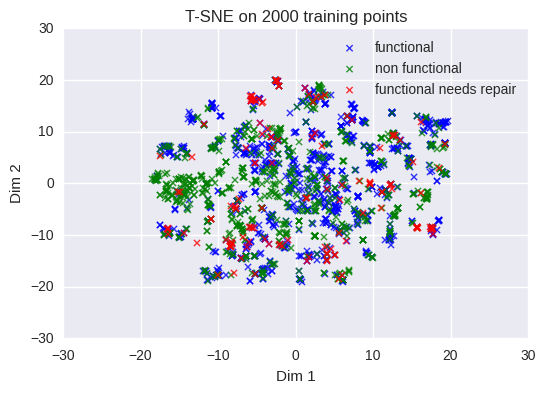

In [17]:
n_points = 2000
perplexity = 25

sample_index = random.sample(range(len(dep_df)),n_points)
X_tsne = TSNE(perplexity=perplexity).fit_transform(x[sample_index])
y_tsne = dep_df.status_group.as_matrix()[sample_index]

plt.figure()
colors = ['g', 'b', 'r']
for value in dep_df.status_group.unique():
    plt.scatter(X_tsne[np.where(y_tsne == value), 0],
                       X_tsne[np.where(y_tsne == value), 1],
                       marker='x', color=colors.pop(randint(len(colors))),
                       linewidth='1', alpha=0.8, label=value)

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE on %d training points' % n_points)
plt.legend(loc='best')
plt.show()

# Model fitting

#### TODO

Try KNN

Try stacking

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, dep_df, test_size=0.2)
print x_train.shape
print y_train.shape

(47520, 113)
(47520, 1)


In [ ]:
start_time = time.time()

rf = RandomForestClassifier()

param_dist = {"max_depth": [2, 3, 4, None],
              "max_features": ["auto", "sqrt", "log2", None],
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators": sp_randint(50, 500),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(x_train, y_train.status_group)

y_test_pred = random_search.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

In [ ]:
random_search.best_estimator_

In [ ]:
importances = pd.DataFrame({"features": features, "importance": random_search.best_estimator_.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

In [25]:
start_time = time.time()

gbm = GradientBoostingClassifier()

param_dist = {"max_depth": [2, 3, 4, None],
              #"loss": ["ls", "lad", "huber", "quantile"],
              "max_features": ["auto", "sqrt", "log2", None],
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators": sp_randint(50, 500)}

# run randomized search
n_iter_search = 20
random_search_gbm = RandomizedSearchCV(gbm, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search_gbm.fit(x_train, y_train.status_group)

y_test_pred = random_search_gbm.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[5578  222  614]
 [ 387  297  143]
 [ 864   78 3697]]
elapsed time: 40987.1428039


In [26]:
random_search_gbm.score(x_test, y_test)

0.80572390572390573

In [27]:
random_search_gbm.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=None, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=7, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=367,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [28]:
importances = pd.DataFrame({"features": features, "importance": random_search_gbm.best_estimator_.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

,features,importance
2,longitude,0.277025
3,latitude,0.221642
112,date_recorded_since_beginning,0.113343
1,gps_height,0.075606
8,funder_OTHER,0.036063
109,date_recorded_weekday,0.033973
5,population,0.033667
83,quality_group_salty,0.018050
6,construction_year,0.012990
10,installer_OTHER,0.012351


In [ ]:
start_time = time.time()

svm = SVC()

param_dist = {
    "C": [2**x for x in range(-5, 8, 1)],
    "gamma": [2**x for x in range(-5, 8, 1)]
}

# run randomized search
n_iter_search = 20
random_search_svm = RandomizedSearchCV(svm, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4)

random_search_svm.fit(x_train, y_train.status_group)

y_test_pred = random_search_svm.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

In [ ]:
random_search_svm.best_estimator_

In [ ]:
start_time = time.time()

svm0 = SVC(C=4, gamma=0.03)
svm1 = SVC(C=3.5, gamma=0.035)
svm2 = SVC(C=4.5, gamma=0.03)
gbm0 = GradientBoostingClassifier(learning_rate=0.1, loss='deviance',
              max_depth=None, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=7, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=350)
gbm1 = GradientBoostingClassifier(learning_rate=0.1, loss='deviance',
              max_depth=None, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=7, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=400)
rf0 = RandomForestClassifier(bootstrap=True, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=450)
rf1 = RandomForestClassifier(bootstrap=True, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=400)
rf2 = RandomForestClassifier(bootstrap=True, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=450)

vc = VotingClassifier(estimators=[("svm0", svm0),
                                  ("svm1", svm1),
                                  ("svm2", svm2),
                                  ("gbm0", gbm0), 
                                  ("gbm1",gbm1),
                                  ("rf0", rf0),
                                 ("rf1", rf1),
                                 ("rf2", rf2)],
                     weights=[2] * 3 + [3] * 2 + [2] * 3)

vc.fit(x_train, y_train)

y_test_pred = vc.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
vc.score(x_test, y_test)

In [ ]:
print (dep_df.status_group == 'functional').sum()
print (dep_df.status_group == 'non functional').sum()